In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import os
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv(r'acceleration_data.txt', header = None, names = columns)
df = df.dropna()

2023-05-25 21:12:10.074852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 21:12:10.236439: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-25 21:12:10.236469: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-25 21:12:10.274026: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-25 21:12:11.241581: W tensorflow/stream_executor/platform/de

In [6]:
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,4.910596e+13,-0.694638,12.680544,0.503953
1,33,Jogging,4.910606e+13,5.012288,11.264028,0.953424
2,33,Jogging,4.910611e+13,4.903325,10.882658,-0.081722
3,33,Jogging,4.910622e+13,-0.612916,18.496431,3.023717
4,33,Jogging,4.910633e+13,-1.184970,12.108489,7.205164


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1732580 entries, 0 to 1732580
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user       int64  
 1   activity   object 
 2   timestamp  float64
 3   x-axis     float64
 4   y-axis     float64
 5   z-axis     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 92.5+ MB


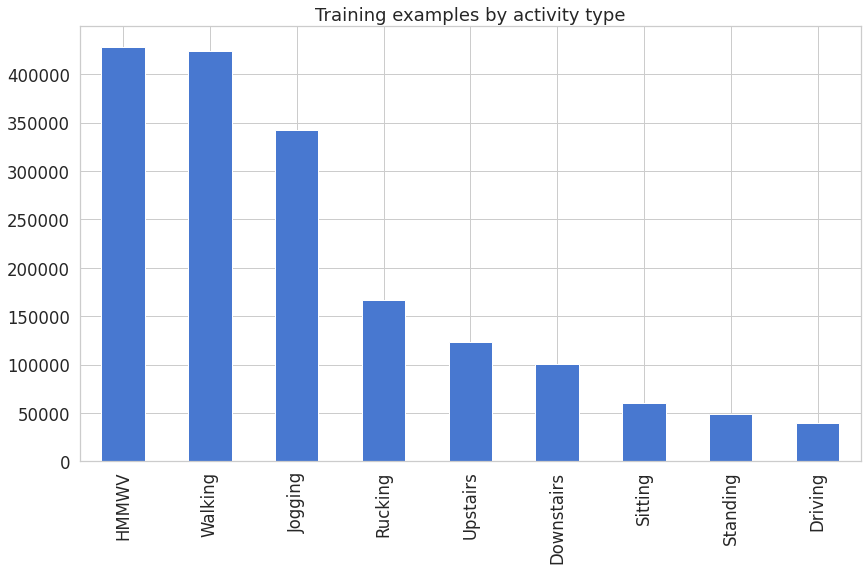

In [8]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

In [9]:
print(df['activity'].value_counts())

HMMWV         428007
Walking       424399
Jogging       342179
Rucking       167012
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Driving        39353
Name: activity, dtype: int64


In [10]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

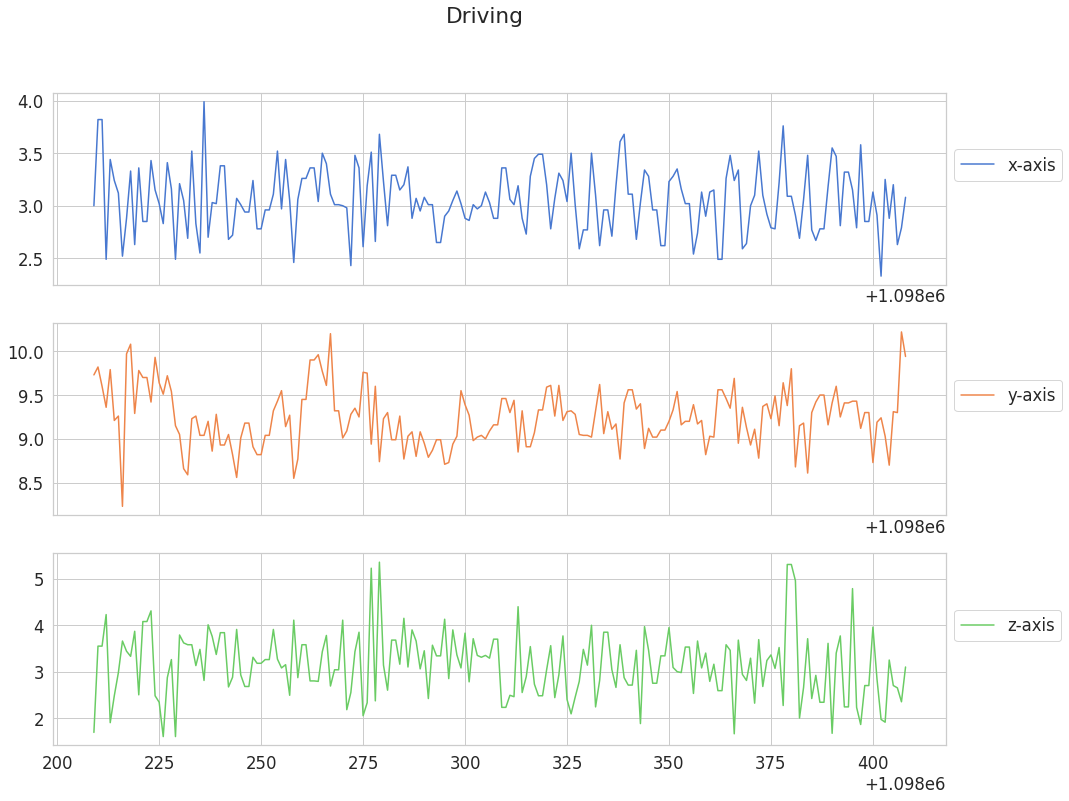

In [11]:
plot_activity("Driving", df)

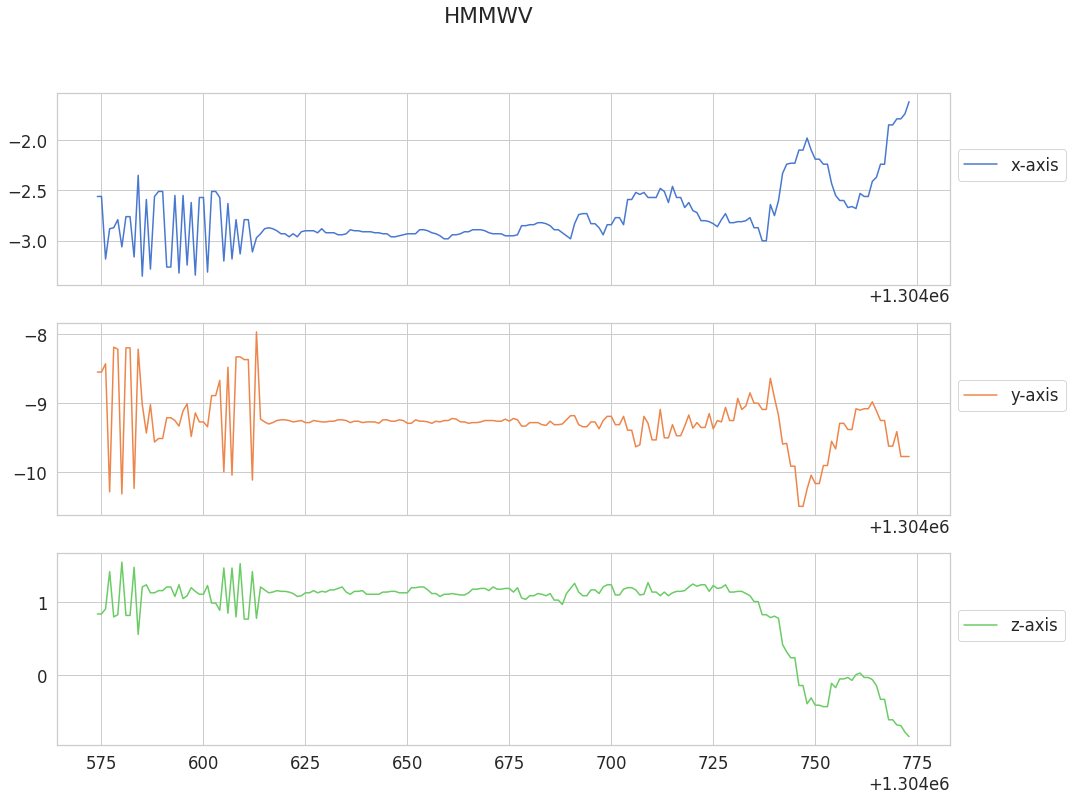

In [12]:
plot_activity("HMMWV", df)

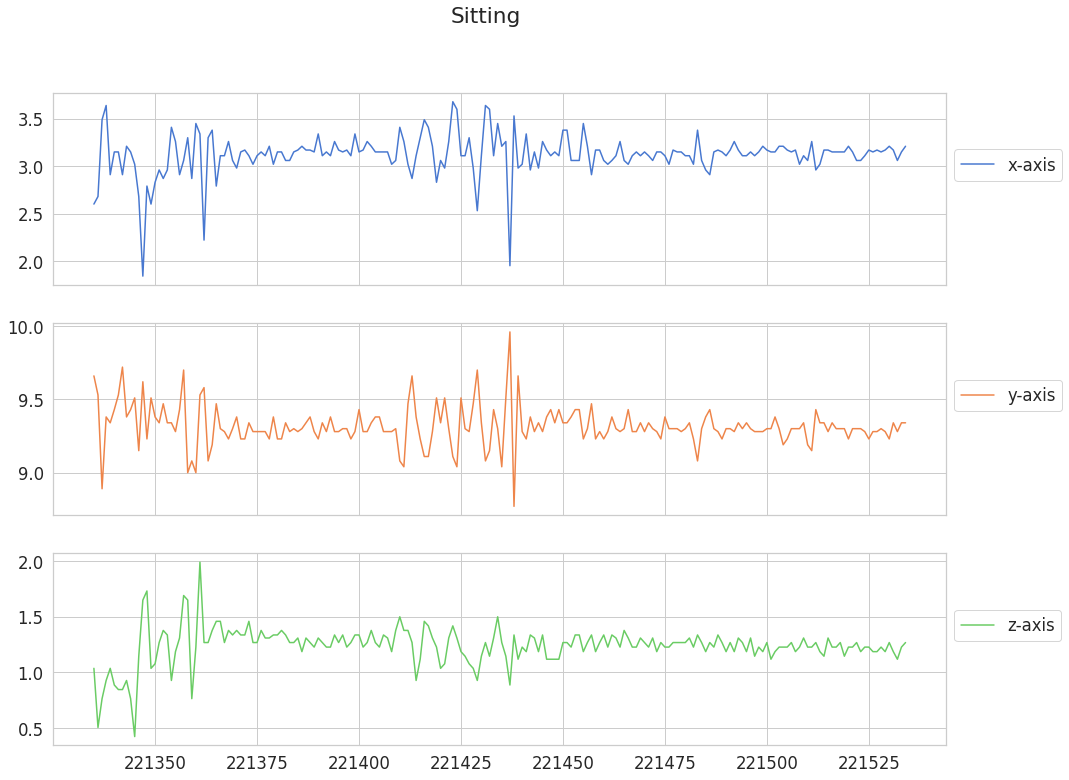

In [8]:
plot_activity("Sitting", df)

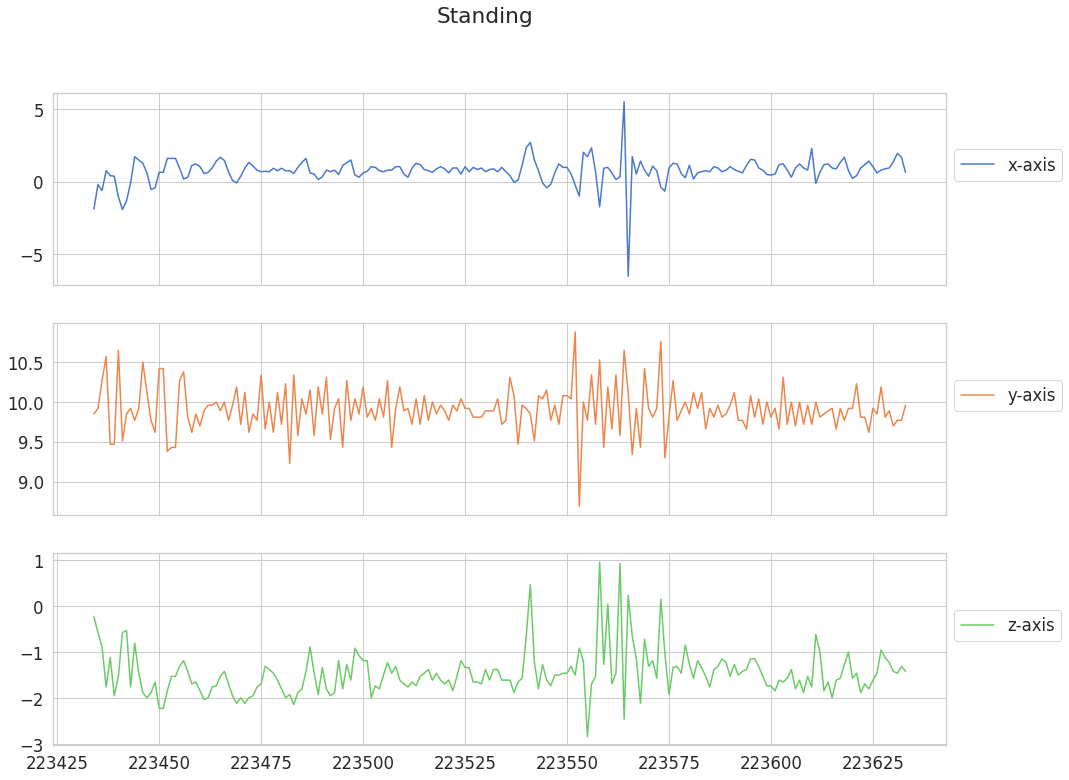

In [9]:
plot_activity("Standing", df)

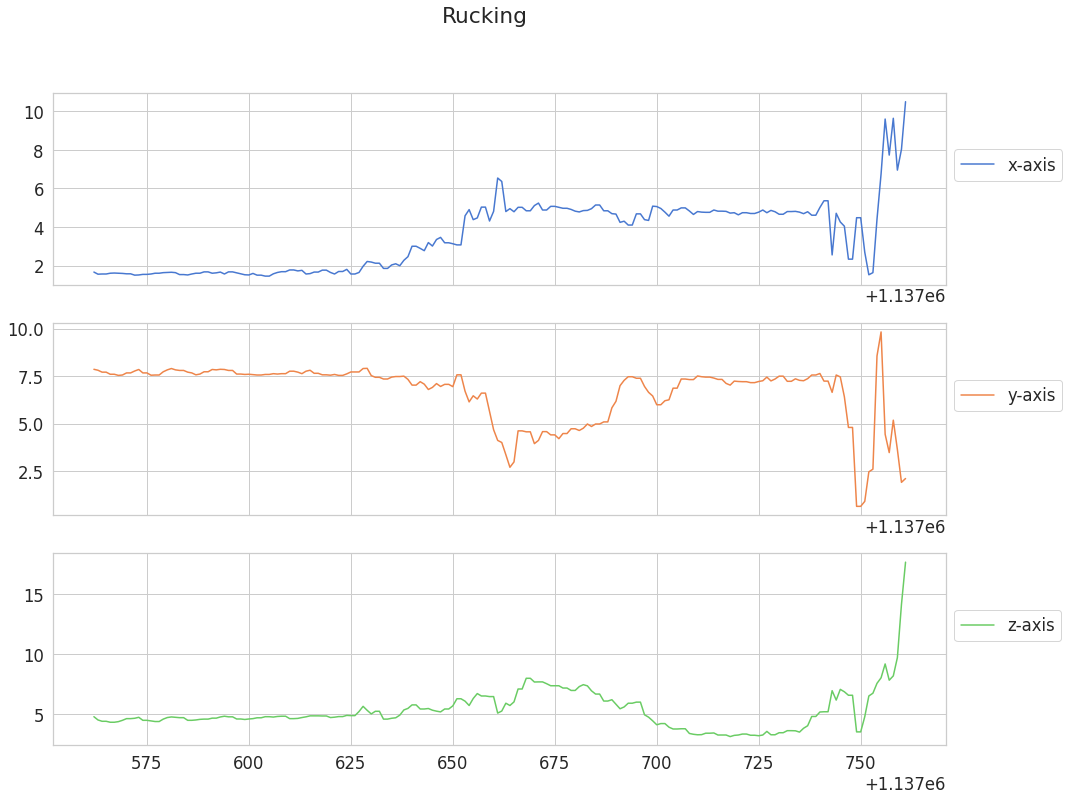

In [10]:
plot_activity("Rucking", df)

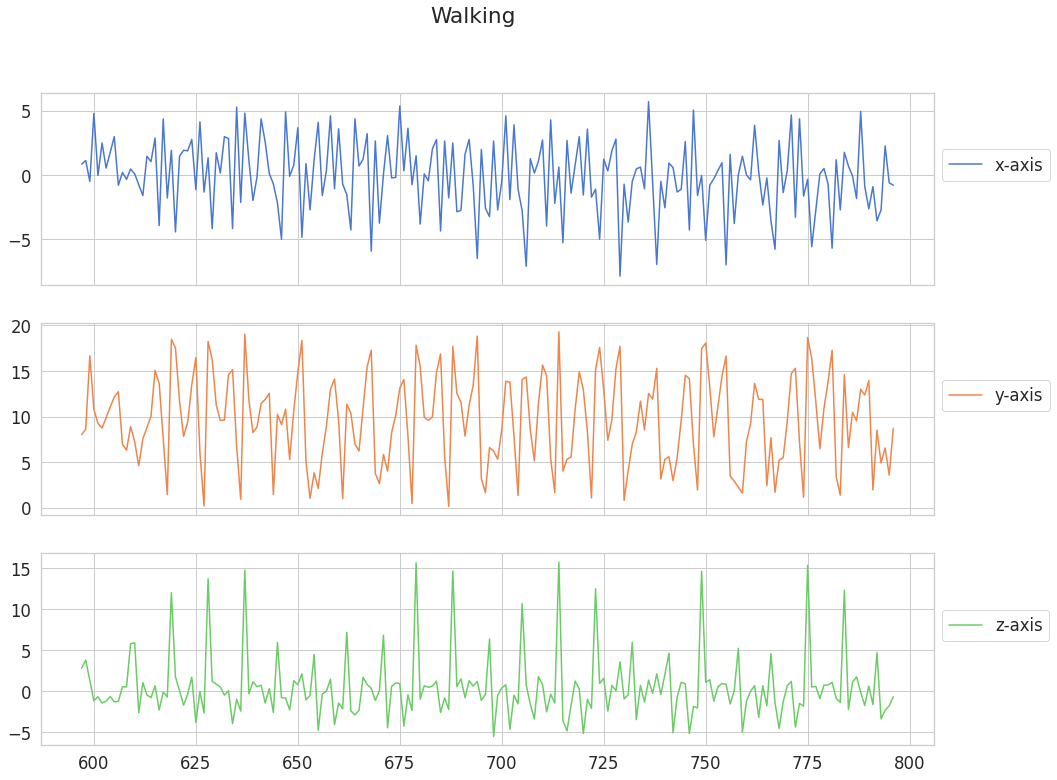

In [11]:
plot_activity("Walking", df)

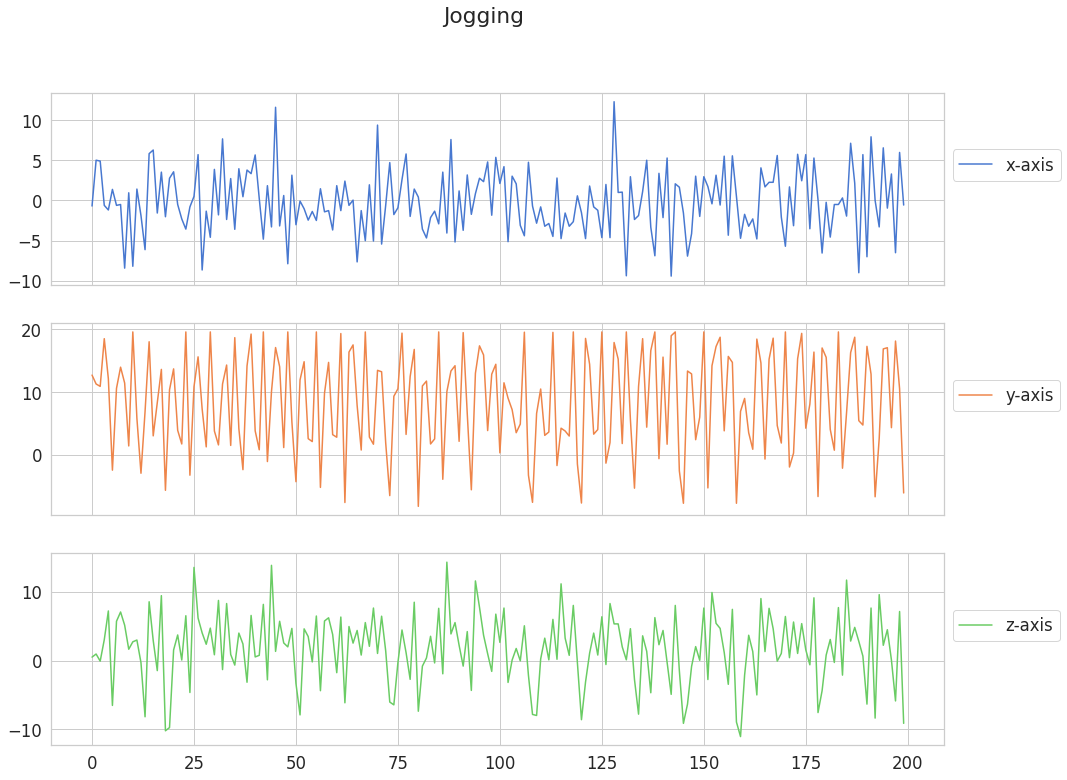

In [12]:
plot_activity("Jogging", df)

In [13]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

/tmp/ipykernel_1938910/1161028679.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
/opt/jupyterhub/lib/python3.9/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
/tmp/ipykernel_1938910/1161028679.py:10: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/refer

In [14]:
np.array(segments).shape

(86619, 3, 200)

In [15]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [16]:
reshaped_segments.shape
#200 rows with each containing 3 elements (x,y,z)

(86619, 200, 3)

In [17]:
labels[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [19]:
print("Size of X training: " + str(len(X_train)))

Size of X training: 69295


In [20]:
y_train[0]#labels for training

array([0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [21]:
y_test[0]#labels for testing

array([0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [22]:
print("Size of X test: " + str(len(X_test)))#x = acceleration data, y = labels

Size of X test: 17324


In [23]:
N_CLASSES = 9
N_HIDDEN_UNITS = 128
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random.normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random.normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random.normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random.normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.compat.v1.nn.rnn_cell.LSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.compat.v1.nn.rnn_cell.MultiRNNCell(lstm_layers)

    outputs, _ = tf.compat.v1.nn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [24]:
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()
X = tf.compat.v1.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.compat.v1.placeholder(tf.float32, [None, N_CLASSES])


In [25]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

/tmp/ipykernel_1220932/1000865717.py:19: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_layers = [tf.compat.v1.nn.rnn_cell.LSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]


Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [26]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.compat.v1.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

In [27]:
LEARNING_RATE = 0.0025

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [28]:
N_EPOCHS = 50
BATCH_SIZE = 1024
saver = tf.compat.v1.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())

train_count = len(X_train)
for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
        continue

    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

2023-05-01 15:35:06.716145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 15:35:06.717663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-01 15:35:06.717914: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-01 15:35:06.718125: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (wpc2ddljuphub1): /proc/driver/nvidia/version does not exist
2023-05-01 15:35:07.333481: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimiza

epoch: 1 test accuracy: 0.8174208998680115 loss: 2.2040343284606934


2023-05-01 15:45:18.441802: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7095808000 exceeds 10% of free system memory.


epoch: 40 test accuracy: 0.9758139252662659 loss: 0.2274208962917328
epoch: 50 test accuracy: 0.972812294960022 loss: 0.21801304817199707

final results: accuracy: 0.972812294960022 loss: 0.21801304817199707


In [45]:
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))

In [100]:
for j in range(1,16):
    sanityTest = pd.read_csv(r"sanity_test_%s.txt" %(j), header = None, names = columns)
    sanityTest = sanityTest.dropna()

    N_TIME_STEPS = 200
    N_FEATURES = 3
    step = 20
    STsegments = []
    for i in range(0, len(sanityTest) - N_TIME_STEPS, step):
        xs = sanityTest['x-axis'].values[i: i + N_TIME_STEPS]
        ys = sanityTest['y-axis'].values[i: i + N_TIME_STEPS]
        zs = sanityTest['z-axis'].values[i: i + N_TIME_STEPS]
        STsegments.append([xs, ys, zs])
    np.array(STsegments).shape

    reshaped_STsegments = np.asarray(STsegments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)

    predicted_y = sess.run(pred_softmax, feed_dict={X:reshaped_STsegments})
    flattened_predicted_y = []
    for i in range(0,len(predicted_y)):
        flattened_predicted_y.append(np.argmax(predicted_y[i]))
    import statistics
    STPredict = statistics.mode(flattened_predicted_y)
    LABELS = ['Standing', 'Driving', 'Walking', 'Jogging', 'Upstairs', 'Sitting', 'Downstairs', 'Rucking', 'HMMWV']
    #print(STPredict)
    print("Test %s: %s" %(j, LABELS[STPredict]))
    #print(flattened_predicted_y)

Test 1: Upstairs
Test 2: Downstairs
Test 3: Walking
Test 4: Walking
Test 5: Downstairs
Test 6: Walking
Test 7: Walking
Test 8: Walking
Test 9: Upstairs
Test 10: Walking
Test 11: Walking
Test 12: Walking
Test 13: Walking
Test 14: Upstairs
Test 15: Walking


In [3]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

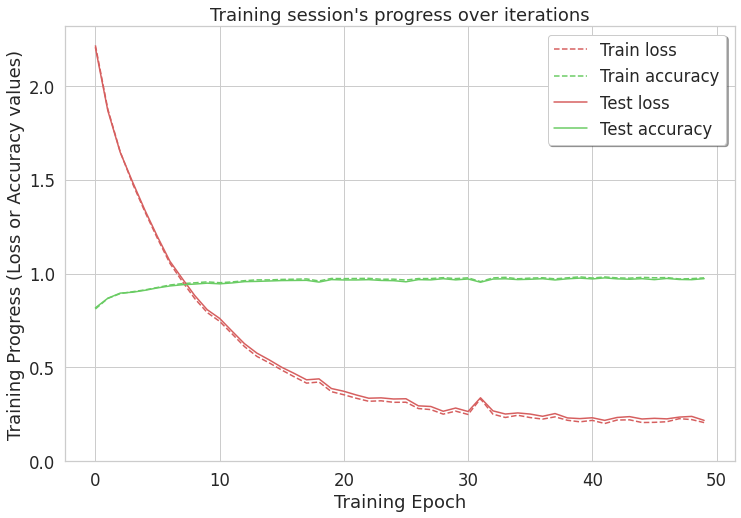

In [19]:
plt.figure(figsize=(12, 8))
plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")
plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

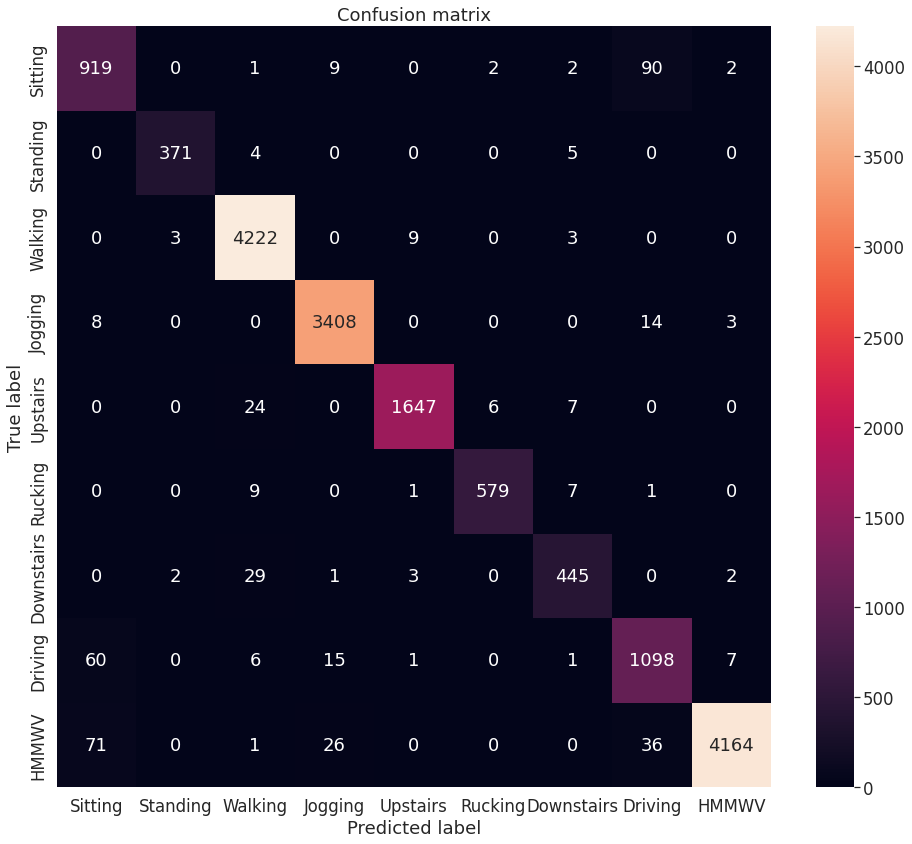

In [20]:
LABELS = ['Sitting', 'Standing', 'Walking', 'Jogging', 'Upstairs', 'Rucking', 'Downstairs', 'Driving', 'HMMWV']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();